# 📊 Customer Churn Analysis with BigQuery & Python 🚀

## **Introduction**

In this notebook, we will analyze customer churn data using Google BigQuery and Python. The dataset contains information about customers. the varibles in the dataset are:

1. customer_id
2. credit_score 
3. country
4. gender
5. age
6. tenure
7. balance
8. products_number
9. credit_card
10. active_member
11. estimated_salary
12. churn, used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

In this notebook we will set up the connection between kaggle and BigQuery, load the data from BigQuery, and perform some basic data analysis. We will also visualize the data using matplotlib and seaborn.

## **Import Libraries**

For this first part we will use `os` to set the environment variables, `pandas` to manipulate the data and `google.cloud` to connect to BigQuery.

In [4]:
import os
import pandas as pd
from google.cloud import bigquery

## Setting up Service Account Credentials

For this project, I wanted to learn how to manage kaggle datasets using bigQuery.Turns out GCP provides service acounts, which can be used to access BigQuery datasets.

First we have to set the environment variables for the service account credentials.

I decided to do this by downloading the key directly from GCP, and saving it on the current codespaces virtual machine I'm using for development. For this process to be secure, I added the folder where this key is stored to the .gitignore file, so it won't be uploaded to GitHub. 

Then, let's set an environment variable where the path to the .json file is saved.


In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/workspaces/ABCBankChurnRate/.config/sa_credentials.json"

## Initializing BigQuery Client

Now, a variable called `client` which is an instance of the `google.cloud.bigquery.Client` class, has it's own methods and attributes. One of it's attributes is `.project`. Printing it will confirm that the client is authenticated, and connected to the GCP project I set up for this data set.

In [6]:
client = bigquery.Client()
print(client.project)

kagglebigquerybankchurn


This `client` object will allow us to perform operations like:

- Running SQL queries on BigQuery Datasets (My main goal on pursuing this specific path)
- Creating datasets and tables (this will be needed to fetch)
- fetch query results as `pandas` DataFrames.

## Fetching Dataset From Kaggle


Now, this dataset is avaliable at kaggle [here](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset). I selected this dataset because the dependent variable is categorical. From my background in analytical chemistry I'm used to work with continuous dependent variables. Then, this is a great oportunity for me to learn how these different systems behave.

let's then import the `kaggle API` first:

In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi
import glob

`glob` will be used to handle the datasets temporarily. I think datasets should not be saved in repositories for efficiency, so we well see below how to address this.

Now, we will temporarily download the dataset using my kaggle credentials, which i have saved in a .env file that is not commited so you cannot see them 😜:

In [8]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set Kaggle credentials from environment variables
if 'KAGGLE_USERNAME' not in os.environ or 'KAGGLE_KEY' not in os.environ:
	raise EnvironmentError("Kaggle credentials not found in environment variables")

in the code above I added a flow control structure that checks if the credentials are set in the environment, if not an error is raised.

Now, let's actually use Kaggle's API to download the dataset.

In [9]:
api = KaggleApi()
api.authenticate()

if no error is raised in the  code above, we successfully authenticated and can access the dataset. Now let's tell python wher it is and where it will be downloaded: 

In [10]:
dataset_name = "gauravtopre/bank-customer-churn-dataset"  # the categorical dependent variable dataset I described to you earlier
download_path = "/tmp"  # Temporary location, not inside this repo

Next we will actually downolad the dataset, into the temporary folder. Once that's done, `glob` will check if it actually is downloaded. Since we know it's a single file, printing the first element `csv_files[0]` is enough.

In [11]:
# Download dataset (ZIP file)
api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# Find the downloaded CSV file
csv_files = glob.glob(f"{download_path}/*.csv")
assert len(csv_files) > 0, "No CSV files found. Check dataset name."
csv_file_path = csv_files[0]  

print(f"✅ Dataset downloaded: {csv_file_path}")

Dataset URL: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset
✅ Dataset downloaded: /tmp/Bank Customer Churn Prediction.csv


## Uploading dataset to bigquery


Ok, we have the dataset saved in that `/tmp` folder, ready to be uploaded to bigquery. 

In the Google Data Analytics Professional certificate, I had the chance to work with bigquery and I found it amazing. From those times I remember each table is within a dataset, and it should have it's own unique identifier. We will need that now, so let's set it up.

In the following code we will define the `dataset_id` and `table_id` our kaggle dataset will have inside bigquery, and we will use to run our queries.

In [12]:
project_id = client.project # This is already defined by the service account
dataset_id = f"{project_id}.churn_analysis"
table_id = "Kaggle_churn"
full_table_id = f"{dataset_id}.{table_id}"

Now that we have defined that unique identifier for the data table, and the dataset whithin it will be saved, we can go ahead and create the dataset:

In [13]:
client.create_dataset(dataset_id, exists_ok=True)

Dataset(DatasetReference('kagglebigquerybankchurn', 'churn_analysis'))


Now check if there is any tables within the dataset. I think there should not because we have not used the kaggle API yet:

In [14]:
tables = {table.table_id for table in client.list_tables(dataset_id)}
print(tables)

{'Kaggle_churn'}


Ok this set comprehension (which I find tremendously efficient) loops trough all the tables within the dataset named `dataset_id`. indeed since right now we haven't used the kaggle functions there is no table yet. Let's get to that.

ok the next chunk of code will upload the dataset to bigquery. 

this process need several configurations to be set, so we are going to save these in the `job_config` variable as follows:

In [15]:
job_config = bigquery.LoadJobConfig(
    autodetect = True,
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1
)

that `job_config` variable will tell the `load_table_from_file` function which schema to use, and what configuration the table load should have.

I've been trough this process many times inside the bigquery site, and every time I felt like selecting options from drop down menus, and pushing buttons was not as reproducible as I would like it to be. Now I'm glad it can be written down in code and anyone can use this for their needs (assuming someone besides me reads this 🤣). 

Now let's do the upload:

In [16]:
with open(csv_file_path, "rb") as source_file:
        job = client.load_table_from_file(source_file, full_table_id, job_config=job_config)

In [17]:
job.result()

LoadJob<project=kagglebigquerybankchurn, location=US, id=d82f3351-499b-4e50-998e-ff00d23513ef>

OK! finally, we have the dataset in biquery and we can query it so it gives us insight on how we should address the data, and which model we could use to predict the bank churn. Let's do a visualization of all variables really quick:

- To do this, first I want to see it with my own eyes, How a result of a SQL query can be shown in a notebook (hyped)

In [18]:
## let's define a query that is analogue to the head function

query = """

SELECT * 
FROM `kagglebigquerybankchurn.churn_analysis.Kaggle_churn`
LIMIT 10

""" 
# Then, run the query using the query method of the client instance:

query_job = client.query(query)
df = query_job.to_dataframe()
# and then actually see the table (can't wait)

df.head()


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15647091,725,Germany,Male,19,0,75888.20,1,0,0,45613.75,0
1,15713826,613,Germany,Female,20,0,117356.19,1,0,0,113557.70,1
2,15633840,781,France,Male,20,0,125023.10,2,1,1,108301.45,0
3,15769915,643,Spain,Female,20,0,133313.34,1,1,1,3965.69,0
4,15652674,539,France,Male,20,0,83459.86,1,1,1,146752.67,0


excellent just wonderful, gracious. Now I can practice my SQL skills right here in a python notebook. isn't that neat?

## Exploratory data analysis

now let's see how the variables are related to the churn rate. For that, we will create the main dataframe again, but will not limit the amount of rows to ten, this dataframe will be named `full_df`


In [19]:
full_query = """
SELECT *
FROM `kagglebigquerybankchurn.churn_analysis.Kaggle_churn`
"""
full_query_job = client.query(full_query)
full_df = full_query_job.to_dataframe()


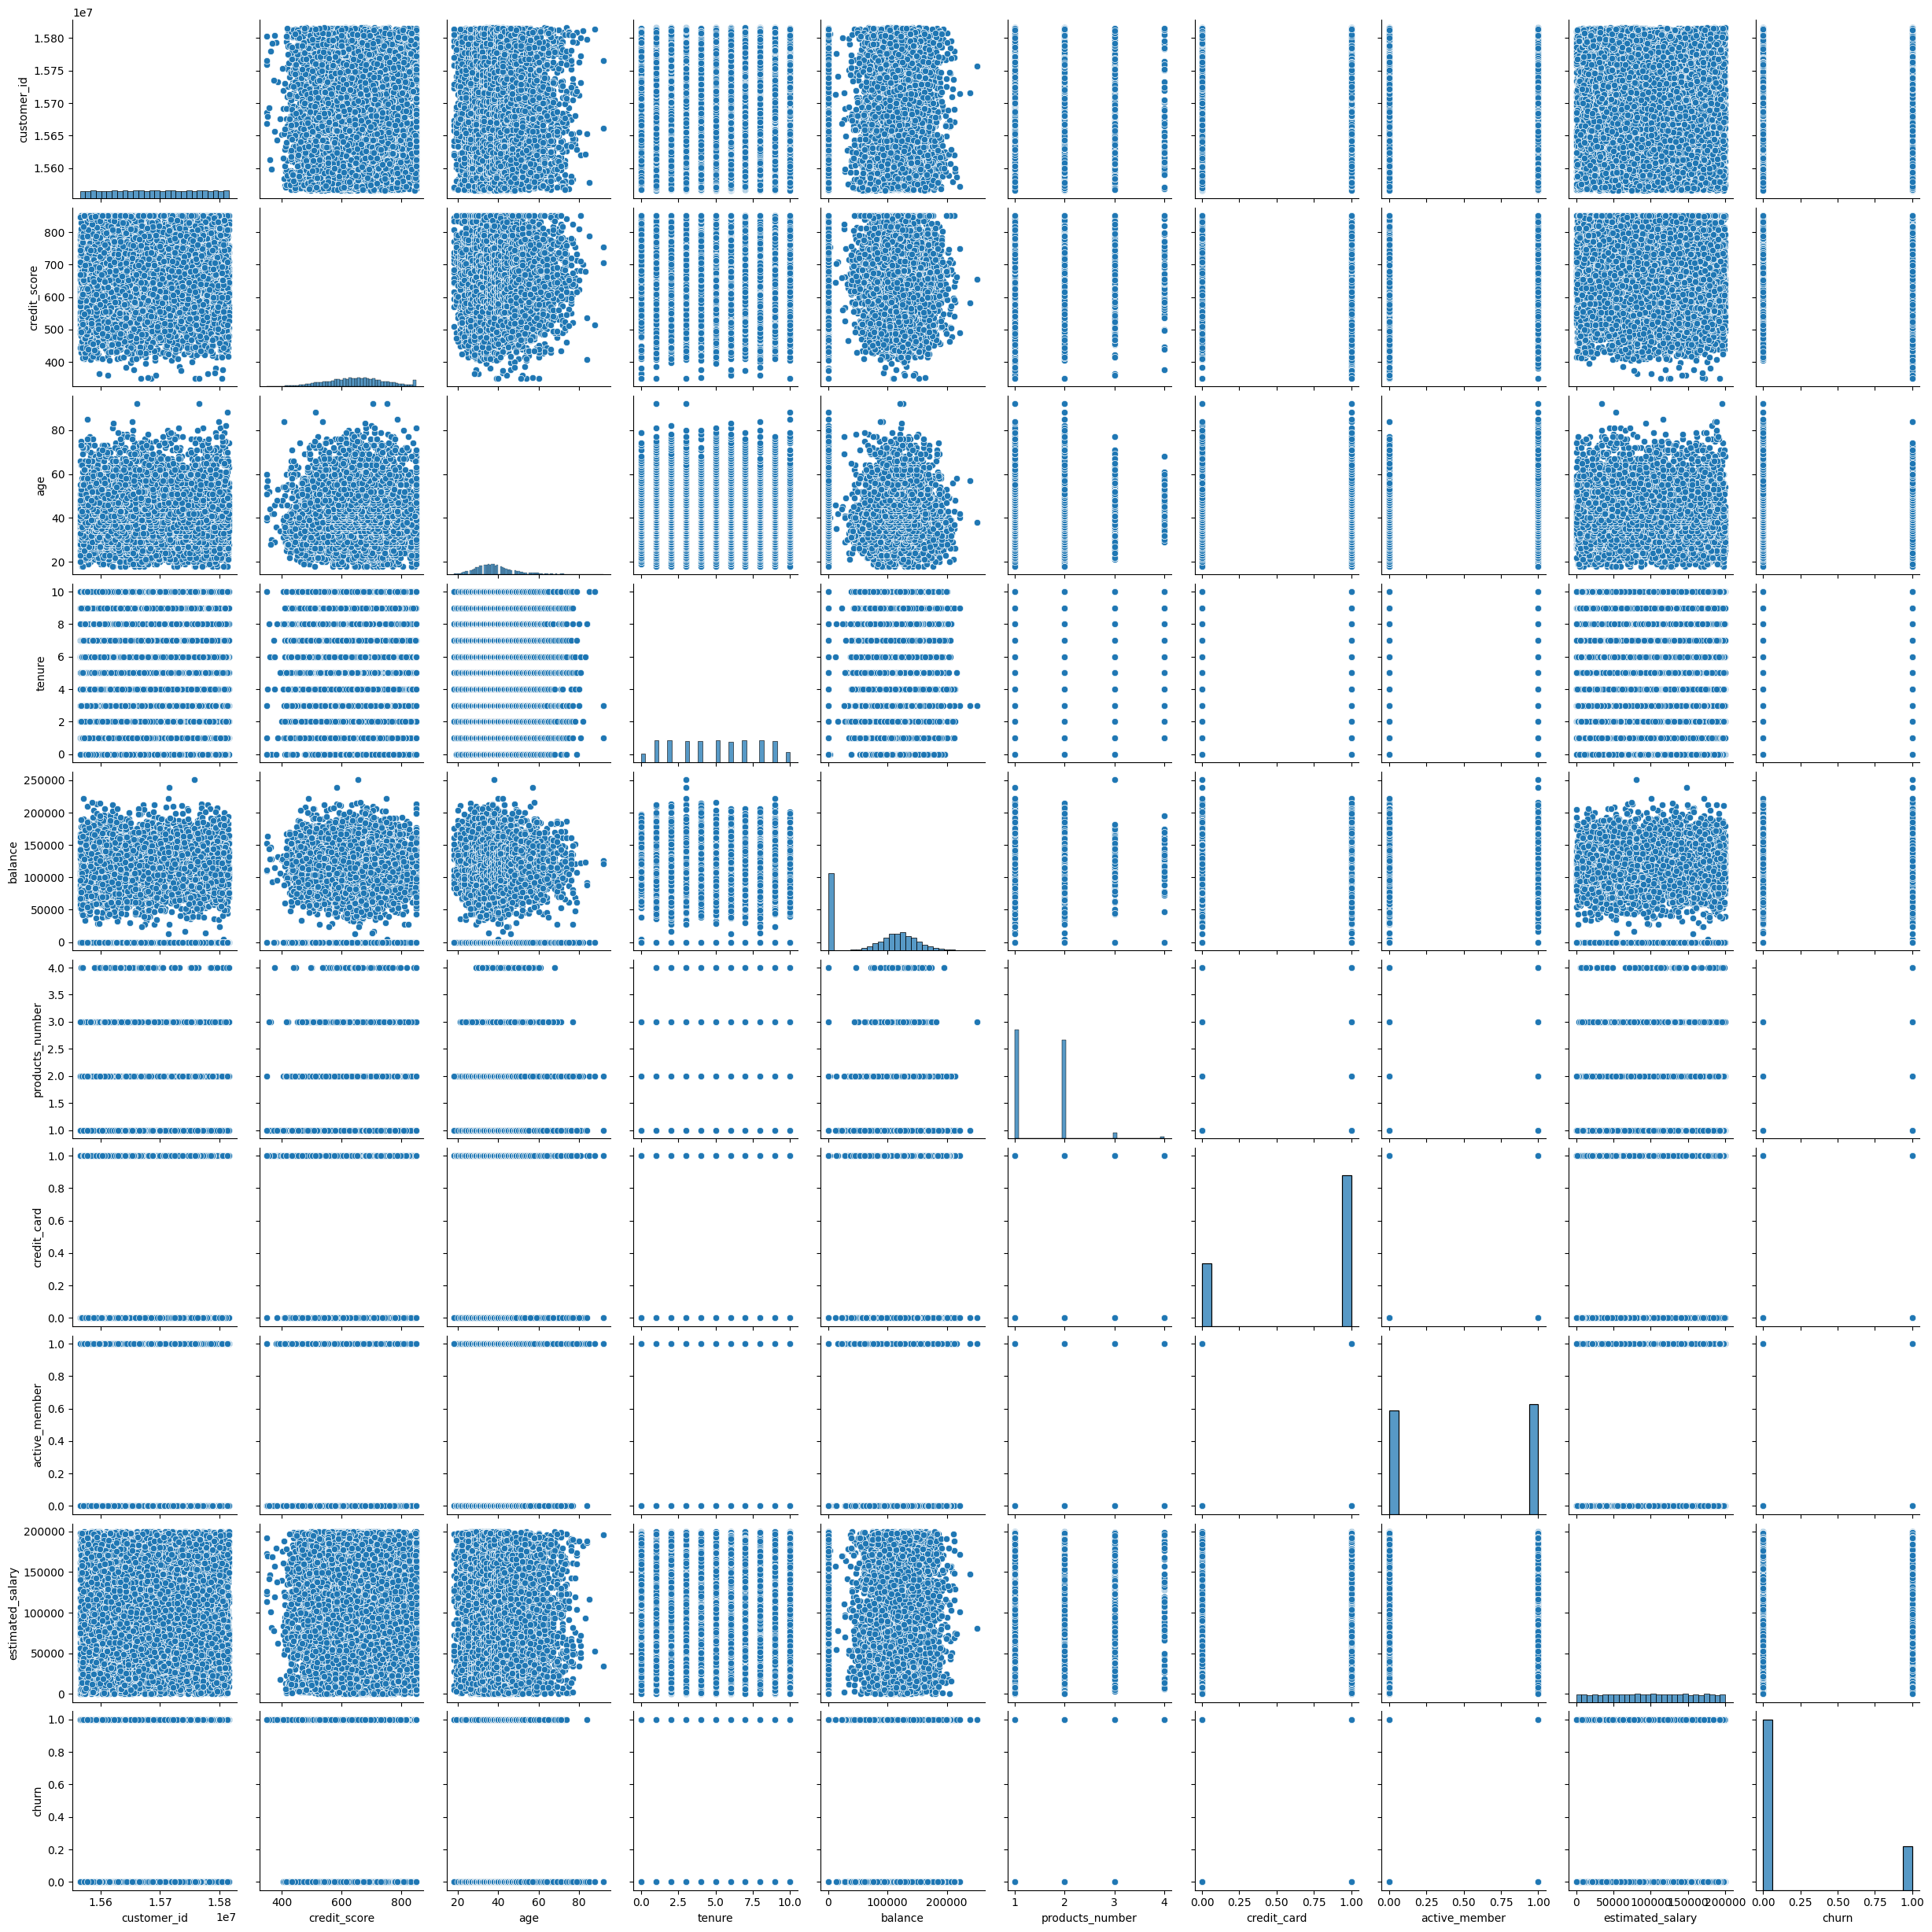

In [20]:
import seaborn as sns
sns.pairplot(full_df)